
# Code section for Comparative Study of Segment Anything Models for Grain Size Analysis: One Step Towards Automation


This code accompanies the publication "Comparative Study of Segment Anything Models for Grain Size Analysis: One Step Towards Automation" and is provided for code availability and reproducibility.

The notebook covers:
1.  Setting up the environment and configuring model loading.
2.  Loading the selected SAM model variant and an example petrographic image.
3.  Performing automatic mask generation using the SAM variant.
4.  Visualizing the generated masks and contours.
5.  Processing the detected masks to extract grain parameters (area, length, width, perimeter).
6.  Loading ground truth annotations.
7.  Matching predicted grains to ground truth annotations for segmentation performance evaluation (Precision, Recall, F1-score).
8.  Analyzing and visualizing grain size distributions derived from the model predictions compared to ground truth.
9.  Saving evaluation metrics and distribution data.

**Prerequisites:**
*   Python 3.12
*   Required libraries: `torch`, `torchvision`, `numpy`, `matplotlib`, `opencv-python`, `pandas`, `scipy`, `scikit-learn`, `openpyxl`. Install using pip: `pip install torch torchvision numpy matplotlib opencv-python pandas scipy scikit-learn openpyxl`
*   **SAM Model Libraries:** You need the specific library or code for the SAM variant you wish to use.
    *   For original SAM (ViT-H/L/B): Install `segment_anything` (`pip install segment_anything`).
    *   For MobileSAM: Install `mobile_sam` (`pip install git+https://github.com/ChaoningZhang/MobileSAM.git`).
    *   For other variants (SlimSAM, TinySAM, RepViT-SAM, FastSAM), you might need to clone their specific repositories and potentially add them to your `sys.path`.
*   **Pre-trained Checkpoints:** Download the checkpoint file (`.pt` or `.pth`) for the specific SAM variant you intend to use.
*   **Data Files:** Provide your example image file and its corresponding ground truth annotation file (expected in a JSON format matching the structure defined in the `get_sam_annotations_from_masks` function or adapted as needed).

Please ensure necessary libraries are installed, checkpoints are downloaded, and data files are placed in appropriate locations relative to this notebook or update the paths below accordingly.


In [26]:

# Standard imports
import os
import time
import json
import xml.etree.ElementTree as ET # Keep in case XML annotation format is needed later, but JSON is used below.
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from scipy.spatial import cKDTree
from concurrent.futures import ThreadPoolExecutor
from typing import List, Dict, Tuple, Any
from scipy.stats import ks_2samp
from sklearn.metrics import mean_squared_error
import torch

# Import necessary components for specific SAM variants
# NOTE: You might need to adjust these imports and potentially add sys.path adjustments
# depending on how you installed or structured the code for different SAM variants.
# This example primarily uses imports compatible with the 'mobile_sam' library structure.
# Force MOBILE_SAM_AVAILABLE to True since we've installed it
MOBILE_SAM_AVAILABLE = True

try:
    from mobile_sam import sam_model_registry as mobile_sam_model_registry
    from mobile_sam import SamAutomaticMaskGenerator as MobileSamAutomaticMaskGenerator
    print("Successfully imported MobileSAM components.")
except ImportError:
    print("MobileSAM components not found. Please install: pip install git+https://github.com/ChaoningZhang/MobileSAM.git")
    MOBILE_SAM_AVAILABLE = False
    mobile_sam_model_registry = None
    MobileSamAutomaticMaskGenerator = None

# You might need similar try-except blocks or conditional imports for other variants
# Example (conceptual, requires 'segment-anything' installed):
# try:
#     from segment_anything import sam_model_registry as generic_sam_model_registry
#     from segment_anything import SamAutomaticMaskGenerator as GenericSamAutomaticMaskGenerator
#     print("Successfully imported standard SAM components.")
#     GENERIC_SAM_AVAILABLE = True
# except ImportError:
#     print("Standard SAM components not found. Please install: pip install segment_anything")
#     GENERIC_SAM_AVAILABLE = False
#     generic_sam_model_registry = None
#     GenericSamAutomaticMaskGenerator = None


Successfully imported MobileSAM components.


# Configuration and Setup

Define model variant, paths, and parameters.

**To use a different SAM variant:**
1.  Change the `MODEL_VARIANT` string.
2.  Update the `CHECKPOINT_PATH` to point to the correct model file.
3.  **Crucially**, modify the "Load Model and Image" cell below to correctly load the model using the specific library/code for that variant. The import mechanism (`sam_model_registry`, `SamAutomaticMaskGenerator` class name, required arguments) may differ between variants.
4.  The `AMBG_PARAMS` dictionary might need tuning for optimal performance with the chosen model variant and image type, although the parameter names should be consistent if the `SamAutomaticMaskGenerator` interface is maintained.
5.  Ensure the necessary library/code for the chosen variant is installed and accessible. -->


In [27]:

# --- Configuration ---
# Model variant selection (Choose one)
MODEL_VARIANT = "MobileSAM"
# MODEL_VARIANT = "SAM-ViT-H" # Example for original SAM, requires code changes below

# Paths
# Adjust these paths based on your file structure and chosen model/data
if MODEL_VARIANT == "MobileSAM":
    CHECKPOINT_PATH = "weights/mobile_sam.pt"
    MODEL_TYPE = "vit_t" # Specific model type string for MobileSAM registry
    SamAutomaticMaskGeneratorClass = MobileSamAutomaticMaskGenerator
    sam_model_registry_func = mobile_sam_model_registry
elif MODEL_VARIANT == "SAM-ViT-H":
    # Example for original SAM - requires 'segment-anything' library
    # If using this, uncomment imports for generic_sam_model_registry and GenericSamAutomaticMaskGenerator
    # and ensure the library is installed.
    # CHECKPOINT_PATH = "../weights/sam_vit_h.pth" # Example path for ViT-H
    # MODEL_TYPE = "vit_h" # Specific model type string for standard SAM registry
    # SamAutomaticMaskGeneratorClass = GenericSamAutomaticMaskGenerator
    # sam_model_registry_func = generic_sam_model_registry
    # print("NOTE: Loading SAM-ViT-H requires the 'segment-anything' library and adjusting imports/paths.")
    # raise NotImplementedError(f"Configuration for {MODEL_VARIANT} is not fully implemented in this example.")
    pass # Placeholder - replace with actual config if enabling

# --- Add elif blocks here for other variants (SlimSAM, TinySAM, RepViT-SAM, FastSAM) ---
# Each variant might require different imports, model_type strings, or loading functions.
else:
     raise ValueError(f"Unknown MODEL_VARIANT: {MODEL_VARIANT}. Please choose a valid option and configure paths/loading.")


# Data Paths
EXAMPLE_IMAGE_PATH = "images/Ooid.jpg" # Path to the example image
GROUND_TRUTH_ANNOTATION_PATH = "annotations/Ooid.json" # Path to the ground truth JSON file
OUTPUT_RESULTS_DIR = f"results/{MODEL_VARIANT.lower()}_example" # Directory to save results (variant specific)

# Image specific settings (adjust for your image)
# Scale factor to convert pixels to real-world units (e.g., micrometers per pixel)
# Example: if 100 pixels = 225 micrometers, scale_factor = 225 / 100 = 2.25
SCALE_FACTOR = 0.68

# Automatic mask generation parameters (adjust for your image and chosen model variant)
# These parameters control the density of points sampled, thresholds for masks, etc.
# Optimal values *may* vary between different SAM model variants.
# Refer to SAM documentation for detailed explanation of each parameter.
AMBG_PARAMS = {
    "points_per_side": 32, # Number of points sampled per side of the image grid
    "points_per_batch": 16, # How many point prompts are processed simultaneously
    "pred_iou_thresh": 0.95, # Threshold on the model's own mask quality prediction
    "stability_score_thresh": 0.95, # Additional threshold on mask stability
    "min_mask_region_area": 100, # Minimum area in pixels for a mask to be kept
    "crop_n_layers": 0, # Number of layers of image cropping to use
    "crop_n_points_downscale_factor": 1, # Downscaling factor for points within crops
    # Add other parameters as needed, e.g., "box_nms_thresh", "crop_overlap_ratio", etc.
    # Example: Smaller min_mask_region_area might be needed for very fine grains,
    # but can increase noise (false positives).
}

# Evaluation settings
IOU_THRESHOLD = 0.5 # IoU threshold for matching predicted masks to ground truth
CENTROID_MATCH_DISTANCE = 100 # Maximum pixel distance for a match candidate

# Device setup
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --- Setup ---
print(f"Selected Model Variant: {MODEL_VARIANT}")
print(f"Using device: {DEVICE}")

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_RESULTS_DIR, exist_ok=True)
print(f"Results will be saved to: {OUTPUT_RESULTS_DIR}")



Selected Model Variant: MobileSAM
Using device: cpu
Results will be saved to: results/mobilesam_example



# Load Model and Image

Load the selected SAM model variant and the image.


In [28]:


# Load the selected SAM model
print(f"Loading {MODEL_VARIANT} model from {CHECKPOINT_PATH}...")

if MODEL_VARIANT == "MobileSAM":
    if not MOBILE_SAM_AVAILABLE:
         raise RuntimeError("MobileSAM variant selected but components not imported. Check installation.")
    if not os.path.exists(CHECKPOINT_PATH):
         raise FileNotFoundError(f"MobileSAM checkpoint not found at {CHECKPOINT_PATH}. Please download it from: https://github.com/ChaoningZhang/MobileSAM/raw/master/weights/mobile_sam.pt")

    sam = sam_model_registry_func[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)

# --- Add elif blocks here for loading other variants ---
# Example (Conceptual for SAM-ViT-H):
# elif MODEL_VARIANT == "SAM-ViT-H":
#     if not GENERIC_SAM_AVAILABLE:
#          raise RuntimeError("SAM-ViT-H variant selected but components not imported. Check installation.")
#     if not os.path.exists(CHECKPOINT_PATH):
#          raise FileNotFoundError(f"SAM-ViT-H checkpoint not found at {CHECKPOINT_PATH}. Please download it.")
#     sam = sam_model_registry_func[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
# elif MODEL_VARIANT == "SlimSAM":
#     # Add SlimSAM loading logic based on its library
#     pass # Placeholder

else:
     # This else should ideally not be reached if the config block validated MODEL_VARIANT,
     # but it's here as a safeguard.
     raise RuntimeError(f"Loading logic for MODEL_VARIANT: {MODEL_VARIANT} is not implemented.")

sam.to(device=DEVICE)
sam.eval()
print("Model loaded successfully.")

# Load Image
print(f"Loading image from {EXAMPLE_IMAGE_PATH}...")
if not os.path.exists(EXAMPLE_IMAGE_PATH):
    raise FileNotFoundError(f"The image file was not found at {EXAMPLE_IMAGE_PATH}. Please check the path.")

image_bgr = cv2.imread(EXAMPLE_IMAGE_PATH)
if image_bgr is None:
     raise IOError(f"Could not read image file at {EXAMPLE_IMAGE_PATH}")
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
image_width = image_rgb.shape[1]
image_height = image_rgb.shape[0]
print(f"Image loaded: {image_width}x{image_height} pixels.")

# Note: The SamAutomaticMaskGenerator interface across SAM variants generally
# expects a HxWx3 NumPy array (uint8). We will use the `image_rgb` NumPy array directly.



Loading MobileSAM model from weights/mobile_sam.pt...
Model loaded successfully.
Loading image from images/Ooid.jpg...
Image loaded: 1537x1024 pixels.



# Define Helper Functions

These functions are used for visualization, mask processing, and evaluation. They operate on standard data structures (NumPy arrays, lists of dictionaries) and should generally work regardless of the SAM variant used for mask generation, as long as the output format of `SamAutomaticMaskGenerator.generate()` is consistent.


In [29]:

# show_anns, draw_mask_contours, compute_length_width_feret,
# get_sam_annotations_from_masks, create_mask_from_polygon_batch,
# calculate_centroids, fast_match_grains, calculate_metrics,
# draw_matched_and_unmatched, analyze_grain_distributions,
# calculate_cumulative_data, evaluate_distribution_similarity)
# --- Paste the code for all helper functions here ---
def show_anns(anns):
    """Displays segmentation masks from SAM on the current matplotlib axes."""
    if len(anns) == 0:
        return
    # Sort masks by area for consistent layering (largest underneath)
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    # Create a transparent overlay image
    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4), dtype=np.uint8) * 255 # Start with white, not black
    img[:,:,3] = 0 # Set alpha channel to 0 (fully transparent)

    # Draw each mask with a random color and fixed transparency
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.random.randint(0, 256, 3)
        # Apply color to the mask area
        img[m] = [*color_mask, 150] # Use 150 alpha for semi-transparency

    ax.imshow(img)

def draw_mask_contours(image: np.ndarray, masks: List[Dict], color: Tuple[int, int, int] = (0, 255, 0), thickness: int = 2) -> np.ndarray:
    """
    Draws contours of masks on the input image.

    Args:
        image: The input image (NumPy array, HxWx3, BGR or RGB).
        masks: A list of mask dictionaries from SAM.
        color: The color for the contours (BGR tuple).
        thickness: The thickness of the contours.

    Returns:
        A copy of the image with contours drawn.
    """
    # Ensure image is in BGR format for OpenCV drawing
    # Simple heuristic: check if max value is 255 and min is 0, and if sum of first pixel is high (likely color)
    is_rgb = image.shape[-1] == 3 and np.max(image) > 1 and np.min(image) >= 0 and image[0,0,:].sum() > 100 # Avoid grayscale sum=0
    if is_rgb:
         result = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    elif image.shape[-1] == 3: # It's a 3-channel image, assume BGR if not RGB by heuristic
         result = image.copy()
    else: # Grayscale or other format
         result = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR) # Convert grayscale to BGR


    for mask in masks:
        # Get the mask segmentation directly
        binary_mask = mask['segmentation'].astype(np.uint8)

        # Find contours (RETR_EXTERNAL retrieves only outer contours)
        # CHAIN_APPROX_SIMPLE compresses horizontal, vertical, and diagonal segments
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Draw contours
        cv2.drawContours(result, contours, -1, color, thickness) # -1 draws all contours found

    # Convert back to RGB if the input was RGB
    if is_rgb:
         return cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    else:
         return result # Return as BGR or grayscale-converted BGR


def compute_length_width_feret(contour: np.ndarray) -> Tuple[float, float]:
    """
    Computes the maximum and minimum Feret diameters (approximated length and width).

    Args:
        contour: A single contour as a NumPy array (Nx1x2).

    Returns:
        A tuple (max_feret_diameter, min_feret_diameter). Returns (0.0, 0.0) for invalid contours.
    """
    if len(contour) < 3:
        return 0.0, 0.0

    try:
        # Get convex hull
        hull = cv2.convexHull(contour)

        # Find minimum area bounding rectangle
        rect = cv2.minAreaRect(hull)
        (center_x, center_y), (width, height), angle = rect

        # The sides of the min area rectangle approximate Feret diameters
        # Length is typically the longer side, width is the shorter
        length = max(width, height)
        width = min(width, height)

        return float(length), float(width) # Ensure float return type
    except Exception as e:
        print(f"Error computing Feret diameters for contour: {e}")
        return 0.0, 0.0 # Return zero if calculation fails


def get_sam_annotations_from_masks(masks: List[Dict], scale_factor: float, image_width: int, image_height: int, coverage_threshold: float = 0.95) -> List[Dict]:
    """
    Processes SAM masks to extract grain properties and formats them as annotations.

    Args:
        masks: A list of mask dictionaries from SAM.
        scale_factor: Factor to convert pixels to real-world units.
        image_width: Width of the original image in pixels.
        image_height: Height of the original image in pixels.
        coverage_threshold: Exclude masks covering more than this fraction of the image area.

    Returns:
        A list of dictionaries, where each dictionary represents a detected grain with its properties.
    """
    annotations = []
    total_image_area = image_width * image_height

    print(f"Processing {len(masks)} SAM masks...")

    for i, mask_data in enumerate(masks):
        mask = mask_data.get('segmentation')
        if mask is None:
             print(f"Warning: Mask {i} missing 'segmentation' key. Skipping.")
             continue

        # Calculate mask area in pixels
        # Use area provided by SAM if available, otherwise calculate from mask
        mask_area_pixels = mask_data.get('area', np.sum(mask.astype(np.uint8)))


        # Calculate coverage
        # Handle potential division by zero if image area is 0 (shouldn't happen with valid image)
        mask_coverage = mask_area_pixels / total_image_area if total_image_area > 0 else 0.0


        # Skip masks that cover more than the threshold (likely background/large features)
        if mask_coverage >= coverage_threshold:
            # print(f"Skipping mask {i} due to large coverage ({mask_coverage:.2f})")
            continue

        # Convert mask to contours
        # cv2.findContours expects a binary mask (0 and >0, typically 0 and 255 or 0 and 1)
        # Ensure the mask is boolean or already uint8 0/255
        if mask.dtype == bool:
             binary_mask = mask.astype(np.uint8) * 255 # Convert boolean mask to uint8 with values 0 and 255
        elif mask.dtype == np.uint8 and np.max(mask) <= 1:
             binary_mask = mask * 255 # Convert 0/1 uint8 to 0/255
        else:
             binary_mask = mask.astype(np.uint8) 

        # Handle potential empty masks after thresholding or conversion
        if np.sum(binary_mask) == 0:
             # print(f"Warning: Binary mask for mask {i} is empty after processing.")
             continue

        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Process each contour found within the mask
        # SAM masks are typically single objects, so usually only one contour per mask
        for contour in contours:
             # Filter out tiny contours that might be artifacts even after min_mask_region_area filtering
             # Check if the calculated area is less than a fraction of the min_mask_region_area param
             if cv2.contourArea(contour) < AMBG_PARAMS.get("min_mask_region_area", 0) * 0.1: # Use a small tolerance
                  # print(f"Skipping tiny contour with area {cv2.contourArea(contour)}.")
                  continue
             
             # Ensure contour has enough points for polygon representation
             if len(contour) < 3:
                 # print(f"Skipping contour with only {len(contour)} points.")
                 continue

             # Format contour to list of (x,y) tuples for storage
             segmentation = [pt[0].tolist() for pt in contour] 
             # Calculate area and true area
             # Using cv2.contourArea for consistency with contour processing
             area_pixels = cv2.contourArea(contour)
             area_true = area_pixels * (scale_factor**2)

             # Calculate length and width using Feret diameter approximation
             length_pixels, width_pixels = compute_length_width_feret(contour)
             length_true = length_pixels * scale_factor
             width_true = width_pixels * scale_factor

             # Calculate perimeter and true perimeter
             perimeter_pixels = cv2.arcLength(contour, True) 
             perimeter_true = perimeter_pixels * scale_factor

             annotations.append({
                 "grain_id": len(annotations) + 1, 
                 "pixel_coords": segmentation,
                 "area_pixels": float(area_pixels),     
                 "area_true": float(area_true),
                 "length_pixels": float(length_pixels), 
                 "length_true": float(length_true), 
                 "width_pixels": float(width_pixels), 
                 "width_true": float(width_true), 
                 "perimeter_pixels": float(perimeter_pixels), 
                 "perimeter_true": float(perimeter_true) 
             })

    print(f"Extracted properties for {len(annotations)} potential grains.")
    return annotations

def create_mask_from_polygon_batch(polygons: List, width: int, height: int) -> np.ndarray:
    """Creates binary masks from a list of polygon coordinates."""
    if not polygons:
        return np.zeros((0, height, width), dtype=np.uint8) # Return empty array if no polygons

    # Ensure polygons are in the correct format (list of np arrays or similar)
    # and handle potential empty polygons
    valid_polygons = []
    for poly in polygons:
        try:
            poly_np = np.array(poly, dtype=np.int32).reshape((-1, 1, 2))
            if poly_np.shape[0] >= 3: # Check if polygon has at least 3 points
                valid_polygons.append(poly_np)
        except Exception as e:
            print(f"Warning: Could not process polygon points: {poly}. Error: {e}")


    if not valid_polygons:
         return np.zeros((0, height, width), dtype=np.uint8) # Return empty if no valid polygons

    masks = np.zeros((len(valid_polygons), height, width), dtype=np.uint8)
    for i, polygon_pts in enumerate(valid_polygons):
        try:
            cv2.fillPoly(masks[i], [polygon_pts], 1)
        except Exception as e:
            print(f"Warning: Could not fill polygon {polygon_pts}. Error: {e}")
            masks[i] = 0 # Ensure the mask remains zero for this invalid polygon
            
    return masks


def calculate_centroids(polygons: List) -> np.ndarray:
    """Calculate centroids for all polygons."""
    centroids = []
    for poly in polygons:
        # Ensure poly is a numpy array for mean calculation
        try:
            poly_np = np.array(poly)
            if poly_np.ndim == 2 and poly_np.shape[0] > 0 and np.isfinite(poly_np).all():
                 centroids.append(np.mean(poly_np, axis=0))
            else:
                 centroids.append([np.nan, np.nan]) # Append NaN for invalid polygons
                 # print(f"Warning: Skipping centroid for invalid polygon data: {poly}")
        except Exception as e:
             print(f"Warning: Error processing polygon {poly} for centroid: {e}")
             centroids.append([np.nan, np.nan]) # Append NaN on error


    return np.array(centroids) if centroids else np.array([])


def fast_match_grains(gt_grains: List[Dict], all_pred_grains: List[Dict],
                     image_width: int, image_height: int,
                     iou_threshold: float = 0.5,
                     max_distance: float = 100) -> Tuple[Dict, Dict, List]:
    """
    Match predicted grains to ground truth grains based on centroid proximity and IoU.
    Tracks all predictions to correctly calculate False Positives.

    Args:
        gt_grains: List of ground truth grain dictionaries. Must have 'grain_id' and 'pixel_coords'.
        all_pred_grains: List of ALL predicted grain dictionaries. Must have 'pixel_coords'.
        image_width: Width of the image.
        image_height: Height of the image.
        iou_threshold: Minimum IoU for a match.
        max_distance: Maximum centroid distance for a match candidate.

    Returns:
        A tuple:
        - matches: Dict mapping GT grain_id to the original index in all_pred_grains.
        - matched_pred_data: Dict mapping original pred_grain_index to simplified prediction data.
        - unmatched_preds: List of prediction dictionaries that were not matched.
    """
    print(f"Attempting to match {len(gt_grains)} ground truth grains with {len(all_pred_grains)} predictions...")

    if not gt_grains or not all_pred_grains:
        print("Warning: No ground truth or predictions to match.")
        return {}, {}, all_pred_grains # Return empty results, all preds are unmatched if no GT


    # Extract polygons and calculate centroids
    # Filter out GT grains missing required data before processing
    valid_gt_grains = [g for g in gt_grains if g.get('grain_id') is not None and g.get('pixel_coords') is not None and len(g.get('pixel_coords', [])) >= 3]
    if len(valid_gt_grains) != len(gt_grains):
         print(f"Warning: Skipped {len(gt_grains) - len(valid_gt_grains)} ground truth grains due to missing data or invalid polygons.")
    gt_polygons = [g['pixel_coords'] for g in valid_gt_grains]
    gt_ids = [g['grain_id'] for g in valid_gt_grains]


    # Filter out predictions missing required data before processing
    valid_pred_indices = [i for i, p in enumerate(all_pred_grains) if p.get('pixel_coords') is not None and len(p.get('pixel_coords', [])) >= 3]
    if len(valid_pred_indices) != len(all_pred_grains):
         print(f"Warning: Skipped {len(all_pred_grains) - len(valid_pred_indices)} predictions due to missing data or invalid polygons.")

    valid_pred_grains = [all_pred_grains[i] for i in valid_pred_indices]
    valid_pred_polygons = [p['pixel_coords'] for p in valid_pred_grains]


    gt_centroids = calculate_centroids(gt_polygons)
    valid_pred_centroids = calculate_centroids(valid_pred_polygons)


    # Filter out invalid centroids (NaNs, etc.) for KDTree
    valid_gt_centroid_indices = [i for i, c in enumerate(gt_centroids) if not np.isnan(c).any()]
    valid_pred_centroid_indices_in_valid_pred = [i for i, c in enumerate(valid_pred_centroids) if not np.isnan(c).any()] # Index within valid_pred_grains list


    if len(valid_gt_centroid_indices) == 0 or len(valid_pred_centroid_indices_in_valid_pred) == 0:
         print("Warning: No valid centroids found for matching.")
         # If no valid GT centroids, all predictions are unmatched
         return {}, {}, all_pred_grains
         # If no valid Pred centroids, all GT are unmatched, all preds are unmatched
         # return {}, {}, all_pred_grains


    final_gt_grains_for_matching = [valid_gt_grains[i] for i in valid_gt_centroid_indices]
    final_gt_centroids = gt_centroids[valid_gt_centroid_indices]
    final_gt_ids = [final_gt_grains_for_matching[i]['grain_id'] for i in range(len(final_gt_grains_for_matching))]

    final_pred_grains_for_matching = [valid_pred_grains[i] for i in valid_pred_centroid_indices_in_valid_pred]
    final_pred_centroids = valid_pred_centroids[valid_pred_centroid_indices_in_valid_pred]
    # Map back to original all_pred_grains indices for the final matching predictions
    final_pred_original_indices = [valid_pred_indices[i] for i in valid_pred_centroid_indices_in_valid_pred]


    # Create KD-tree for efficient nearest neighbor search
    tree = cKDTree(final_pred_centroids)


    # Initialize containers
    matches = {} # {gt_grain_id: original_pred_grain_index}
    matched_pred_data = {} # {original_pred_grain_index: simplified_data}
    # Keep track of which original prediction indices are used in matches
    matched_pred_original_indices_set = set()

    # Create masks for IoU calculation - only for the grains/preds with valid centroids/polygons
    print("Creating masks for IoU calculation...")
    final_gt_polygons = [g['pixel_coords'] for g in final_gt_grains_for_matching]
    final_pred_polygons = [p['pixel_coords'] for p in final_pred_grains_for_matching] # These are already filtered

    gt_masks = create_mask_from_polygon_batch(final_gt_polygons, image_width, image_height)
    pred_masks = create_mask_from_polygon_batch(final_pred_polygons, image_width, image_height)

    if gt_masks.shape[0] == 0 or pred_masks.shape[0] == 0:
         print("Warning: No valid masks generated for IoU calculation after filtering.")
         return {}, {}, all_pred_grains # If no masks, no matches possible

    print("Starting matching process...")
    # Match grains based on centroid proximity and IoU
    for i, gt_centroid in enumerate(final_gt_centroids):
        gt_grain_id = final_gt_ids[i]

        # Find nearby predictions using KDTree
        nearby_final_pred_indices = tree.query_ball_point(gt_centroid, max_distance)

        if not nearby_final_pred_indices:
            continue # No nearby predictions within distance

        # Map nearby indices (which are indices within final_pred_centroids/grains)
        # back to their original indices in the all_pred_grains list
        nearby_original_indices = [final_pred_original_indices[idx] for idx in nearby_final_pred_indices]


        # Filter out predictions that have already been matched
        unmatched_nearby_original_indices = [idx for idx in nearby_original_indices if idx not in matched_pred_original_indices_set]

        if not unmatched_nearby_original_indices:
             continue # All nearby predictions already matched or filtered

        # Calculate IoUs for the remaining nearby, unmatched predictions
        ious = []
        original_indices_for_iou = []
        for original_idx in unmatched_nearby_original_indices:
             # Find the index of this original_idx within the final_pred_original_indices list
             # This gives us the correct index to use with the `pred_masks` array
             try:
                  final_pred_mask_idx = final_pred_original_indices.index(original_idx)
                  iou = np.sum(np.logical_and(gt_masks[i], pred_masks[final_pred_mask_idx])) / \
                        np.sum(np.logical_or(gt_masks[i], pred_masks[final_pred_mask_idx]))
                  ious.append(iou)
                  original_indices_for_iou.append(original_idx)
             except ValueError:
                  # This should not happen if logic is correct, but included as safeguard
                  print(f"Error: Original index {original_idx} not found in final_pred_original_indices. Skipping IoU calculation.")
                  continue


        if not ious:
             continue # No valid IoUs could be calculated

        best_iou_relative_idx = np.argmax(ious)
        best_iou = ious[best_iou_relative_idx]

        if best_iou > iou_threshold:
            # Get the original index of the best matching prediction
            best_pred_original_idx = original_indices_for_iou[best_iou_relative_idx]

            # This check is redundant if filtering worked correctly, but doesn't hurt
            if best_pred_original_idx not in matched_pred_original_indices_set:
                matches[gt_grain_id] = best_pred_original_idx
                matched_pred_original_indices_set.add(best_pred_original_idx) # Mark this prediction as used

                # Store simplified data for the matched prediction
                # Use properties directly from the all_pred_grains list
                matched_pred_data[best_pred_original_idx] = {
                    'pixel_coords': all_pred_grains[best_pred_original_idx].get('pixel_coords', []),
                    'area_true': all_pred_grains[best_pred_original_idx].get('area_true', 0.0),
                    'length_true': all_pred_grains[best_pred_original_idx].get('length_true', 0.0),
                    'area_pixels': all_pred_grains[best_pred_original_idx].get('area_pixels', 0.0), # Also store pixel area for context
                    'length_pixels': all_pred_grains[best_pred_original_idx].get('length_pixels', 0.0), # Also store pixel length
                }

    # Determine unmatched predictions: any prediction in all_pred_grains whose original index
    # is NOT in the matched_pred_original_indices_set.
    unmatched_preds = [all_pred_grains[i] for i in range(len(all_pred_grains)) if i not in matched_pred_original_indices_set]

    print(f"Matching complete.")
    print(f"  Total ground truth grains processed for matching: {len(final_gt_grains_for_matching)}")
    print(f"  Total predictions processed for matching: {len(final_pred_grains_for_matching)}")
    print(f"  Successfully matched GT grains: {len(matches)}")
    print(f"  Matched predictions count: {len(matched_pred_original_indices_set)}") # Should be equal to len(matches)
    print(f"  Unmatched predictions (FP) count: {len(unmatched_preds)}")

    return matches, matched_pred_data, unmatched_preds


def calculate_metrics(gt_data: List[Dict],
                      all_predictions: List[Dict],
                      matches: Dict,
                      unmatched_preds: List) -> Dict[str, Any]:
    """
    Calculate comprehensive segmentation performance metrics (Precision, Recall, F1).

    Args:
        gt_data: List of original ground truth grain dictionaries.
        all_predictions: List of ALL original predicted grain dictionaries.
        matches: Dictionary mapping GT grain_id to original prediction index.
        unmatched_preds: List of prediction dictionaries that were not matched (False Positives).

    Returns:
        A dictionary containing the calculated metrics.
    """
    total_gt = len(gt_data)
    total_pred = len(all_predictions)
    matched_count = len(matches) # Number of ground truth grains that found a match

    # True Positives (TP): Number of ground truth grains that were correctly matched to a prediction.
    # This is equivalent to the number of successful matches found.
    tp = matched_count

    # False Positives (FP): Predictions that did not match any ground truth grain.
    # This is exactly the number of unmatched predictions.
    fp = len(unmatched_preds)

    # False Negatives (FN): Ground truth grains that did not find a match.
    fn = total_gt - tp

    # Calculate metrics
    # Add handling for division by zero if denominators are zero
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    return {
        "total_predictions": total_pred,
        "total_ground_truth": total_gt,
        "true_positives": tp,
        "false_positives": fp,
        "false_negatives": fn,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "matched_gt_count": matched_count, # Number of GT grains matched
        "matched_pred_count": len(set(matches.values())), # Number of unique predictions that were matched (should equal matched_gt_count)
        "unmatched_pred_count": fp # Same as false_positives
    }


def draw_matched_and_unmatched(image: np.ndarray, gt_data: List[Dict], all_pred_grains: List[Dict],
                              matches: Dict, unmatched_preds: List) -> np.ndarray:
    """
    Draws contours of ground truth, matched predictions, and unmatched predictions
    on the image for visualization.

    Args:
        image: Original image (NumPy array, HxWx3, RGB).
        gt_data: List of ground truth grain dictionaries.
        all_pred_grains: List of ALL predicted grain dictionaries.
        matches: Dictionary mapping GT grain_id to prediction index.
        unmatched_preds: List of prediction dictionaries that were not matched (FP).

    Returns:
        Image with colored contours.
    """
    # Create a copy of the image and ensure it's in BGR for OpenCV drawing
    # Using the same heuristic as draw_mask_contours
    is_rgb = image.shape[-1] == 3 and np.max(image) > 1 and np.min(image) >= 0 and image[0,0,:].sum() > 100
    if is_rgb:
         result = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    elif image.shape[-1] == 3:
         result = image.copy()
    else:
         result = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Draw Ground Truth contours (Blue for unmatched, to identify FN)
    # Iterate through GT data and check if its ID is in the keys of the 'matches' dictionary
    matched_gt_ids = set(matches.keys())
    for gt_grain in gt_data:
        gt_id = gt_grain.get('grain_id')
        contour_coords = gt_grain.get('pixel_coords', [])
        if gt_id is not None and contour_coords and gt_id not in matched_gt_ids:
             try:
                  contour = np.array(contour_coords, dtype=np.int32)
                  if len(contour) >= 3: # Ensure valid contour for drawing
                       cv2.drawContours(result, [contour], -1, (255, 0, 0), 2) # Blue for unmatched GT (FN)
             except Exception as e:
                  print(f"Warning: Could not draw contour for unmatched GT grain {gt_id}. Error: {e}")


    # Draw ALL Predicted contours
    # Matched predictions in Green, Unmatched predictions in Red
    # Iterate through the original list of all predictions using their index
    matched_pred_original_indices_set = set(matches.values())

    for i, pred in enumerate(all_pred_grains):
        contour_coords = pred.get('pixel_coords', [])
        if contour_coords:
             try:
                 contour = np.array(contour_coords, dtype=np.int32)
                 if len(contour) >= 3: # Ensure valid contour for drawing
                    if i in matched_pred_original_indices_set:
                        # This prediction was matched to a GT
                        cv2.drawContours(result, [contour], -1, (0, 255, 0), 2) # Green for Matched Predictions (TP)
                    else:
                        # This prediction was NOT matched (it's an unmatched_pred / FP)
                        cv2.drawContours(result, [contour], -1, (0, 0, 255), 2) # Red for Unmatched Predictions (FP)
             except Exception as e:
                  print(f"Warning: Could not draw contour for prediction index {i}. Error: {e}")


    # Convert back to RGB for matplotlib display
    if is_rgb:
        return cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    else:
         return result # Return as BGR or grayscale-converted BGR


def analyze_grain_distributions(gt_data: List[Dict],
                                all_pred_grains: List[Dict],
                                matched_pred_data: Dict) -> Tuple[pd.DataFrame, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Analyzes and visualizes grain size (area) and length distributions.

    Args:
        gt_data: List of ground truth grain dictionaries.
        all_pred_grains: List of ALL predicted grain dictionaries.
        matched_pred_data: Dictionary of data for predictions that were matched.

    Returns:
        A tuple containing:
        - DataFrame with summary statistics.
        - NumPy arrays of ground truth areas/lengths.
        - NumPy arrays of all prediction areas/lengths.
        - NumPy arrays of matched prediction areas/lengths.
    """
    # Extract sizes and lengths, handling potential missing keys or zero values
    gt_sizes = np.array([grain.get('area_true', 0.0) for grain in gt_data if grain.get('area_true', 0.0) > 0])
    gt_lengths = np.array([grain.get('length_true', 0.0) for grain in gt_data if grain.get('length_true', 0.0) > 0])

    # Use the pre-computed properties from get_sam_annotations_from_masks
    all_pred_sizes = np.array([grain.get('area_true', 0.0) for grain in all_pred_grains if grain.get('area_true', 0.0) > 0])
    all_pred_lengths = np.array([grain.get('length_true', 0.0) for grain in all_pred_grains if grain.get('length_true', 0.0) > 0])

    # Extract sizes and lengths for *matched* predictions from the matched_pred_data dictionary
    # The keys in matched_pred_data are the original indices from all_pred_grains
    # The values are the simplified dictionaries {pixel_coords, area_true, length_true}
    matched_pred_list = list(matched_pred_data.values()) # Convert dict values to a list
    matched_pred_sizes = np.array([grain.get('area_true', 0.0) for grain in matched_pred_list if grain.get('area_true', 0.0) > 0])
    matched_pred_lengths = np.array([grain.get('length_true', 0.0) for grain in matched_pred_list if grain.get('length_true', 0.0) > 0])


    print(f"\nDistribution Data Counts:")
    print(f"  Ground Truth grains: {len(gt_sizes)}")
    print(f"  All predictions: {len(all_pred_sizes)}")
    print(f"  Matched predictions: {len(matched_pred_sizes)}") # Count of predictions that matched a GT

    # Create summary DataFrame (align lengths for display if needed, or just show counts)
    # Using Series.describe() is a good way to get standard stats
    stats_dict = {}
    if len(gt_sizes) > 0:
         stats_dict['GT_Areas'] = pd.Series(gt_sizes).describe()
         stats_dict['GT_Lengths'] = pd.Series(gt_lengths).describe()
    if len(all_pred_sizes) > 0:
        stats_dict['All_Pred_Areas'] = pd.Series(all_pred_sizes).describe()
        stats_dict['All_Pred_Lengths'] = pd.Series(all_pred_lengths).describe()
    if len(matched_pred_sizes) > 0:
         stats_dict['Matched_Areas'] = pd.Series(matched_pred_sizes).describe()
         stats_dict['Matched_Lengths'] = pd.Series(matched_pred_lengths).describe()

    # Create a DataFrame from the statistics, handling case where some categories might be empty
    if stats_dict:
        # Create a DataFrame from the combined descriptions. 'index' will be the stats name (count, mean, etc.)
        df_stats = pd.DataFrame(stats_dict)
        # Ensure all standard stats are present, even if some are NaN
        all_indices = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
        df_stats = df_stats.reindex(all_indices)
    else:
        df_stats = pd.DataFrame() # Empty DataFrame if no data

    print("\nSummary Statistics:")
    print(df_stats)

    # Visualization (only plot if there's data)
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))

    # --- Histograms ---
    # Use a function or loop to avoid repetition and handle empty data
    def plot_histogram(ax, data, label, color, bins=30):
        if data.size > 0:
            ax.hist(data, bins=bins, alpha=0.6, label=label, density=True, color=color)

    plot_histogram(axs[0, 0], gt_sizes, 'Ground Truth', 'blue')
    plot_histogram(axs[0, 0], all_pred_sizes, 'All Predictions', 'orange')
    plot_histogram(axs[0, 0], matched_pred_sizes, 'Matched Predictions', 'green')

    plot_histogram(axs[0, 1], gt_lengths, 'Ground Truth', 'blue')
    plot_histogram(axs[0, 1], all_pred_lengths, 'All Predictions', 'orange', bins=100) # More bins for length
    plot_histogram(axs[0, 1], matched_pred_lengths, 'Matched Predictions', 'green')


    # Set titles and scales for histograms
    axs[0, 0].set_xscale('log')
    axs[0, 0].set_title('Grain Size Distribution (Area)')
    axs[0, 0].set_xlabel(f'Area ({SCALE_FACTOR*SCALE_FACTOR:.2f} unit²)') # Adjusted unit label
    axs[0, 0].set_ylabel('Density')
    axs[0, 0].legend()

    axs[0, 1].set_xscale('log')
    axs[0, 1].set_title('Grain Size Distribution (Length)')
    axs[0, 1].set_xlabel(f'Length ({SCALE_FACTOR:.2f} unit)') # Adjusted unit label
    axs[0, 1].set_ylabel('Density')
    axs[0, 1].legend()

    # --- CDFs ---
    # Use a function or loop to avoid repetition and handle empty data
    def plot_cdf(ax, data, label, color):
        if data.size > 0:
            ax.plot(np.sort(data),
                    np.linspace(0, 1, len(data)),
                    label=label, color=color)

    plot_cdf(axs[1, 0], gt_sizes, 'Ground Truth', 'blue')
    plot_cdf(axs[1, 0], all_pred_sizes, 'All Predictions', 'orange')
    plot_cdf(axs[1, 0], matched_pred_sizes, 'Matched Predictions', 'green')

    plot_cdf(axs[1, 1], gt_lengths, 'Ground Truth', 'blue')
    plot_cdf(axs[1, 1], all_pred_lengths, 'All Predictions', 'orange')
    plot_cdf(axs[1, 1], matched_pred_lengths, 'Matched Predictions', 'green')


    # Set titles and scales for CDFs
    axs[1, 0].set_xscale('log')
    axs[1, 0].set_title('Cumulative Distribution (Area)')
    axs[1, 0].set_xlabel(f'Area ({SCALE_FACTOR*SCALE_FACTOR:.2f} unit²)') # Adjusted unit label
    axs[1, 0].set_ylabel('Cumulative Probability')
    axs[1, 0].legend()

    axs[1, 1].set_xscale('log')
    axs[1, 1].set_title('Cumulative Distribution (Length)')
    axs[1, 1].set_xlabel(f'Length ({SCALE_FACTOR:.2f} unit)') # Adjusted unit label
    axs[1, 1].set_ylabel('Cumulative Probability')
    axs[1, 1].legend()


    plt.tight_layout()
    plt.show()

    # Return the data arrays for further analysis (e.g., KS statistic, NRMSE)
    return df_stats, gt_sizes, all_pred_sizes, matched_pred_sizes, gt_lengths, all_pred_lengths, matched_pred_lengths


def calculate_cumulative_data(sizes: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Calculate cumulative frequencies and percentiles for a sorted array."""
    if len(sizes) == 0:
        return np.array([]), np.array([])
    sorted_sizes = np.sort(sizes)
    cumulative_freq = np.arange(1, len(sorted_sizes) + 1) / len(sorted_sizes)
    return sorted_sizes, cumulative_freq


def evaluate_distribution_similarity(gt_dist: np.ndarray, pred_dist: np.ndarray) -> Dict[str, float]:
    """
    Evaluates the similarity between two distributions using KS statistic and NRMSE.

    Args:
        gt_dist: NumPy array of ground truth distribution values.
        pred_dist: NumPy array of predicted distribution values.

    Returns:
        Dictionary containing KS statistic and NRMSE.
    """
    metrics = {}

    # Kolmogorov-Smirnov Test (compares empirical distribution functions)
    # Lower KS statistic indicates greater similarity.
    if len(gt_dist) > 1 and len(pred_dist) > 1:
        try:
            ks_statistic, ks_pvalue = ks_2samp(gt_dist, pred_dist)
            metrics['ks_statistic'] = float(ks_statistic) # Ensure float
            metrics['ks_pvalue'] = float(ks_pvalue) # Ensure float
        except Exception as e:
            print(f"Warning: Error computing KS statistic: {e}")
            metrics['ks_statistic'] = np.nan
            metrics['ks_pvalue'] = np.nan
    else:
        metrics['ks_statistic'] = np.nan
        metrics['ks_pvalue'] = np.nan
        print("Warning: Cannot compute KS statistic for distributions with less than 2 samples.")

    # Normalized Root Mean Squared Error (NRMSE) on the cumulative distributions
    # This requires comparing the cumulative distributions at a common set of points.
    # A simple approach is to compare at percentiles.

    if len(gt_dist) > 0 and len(pred_dist) > 0:
        try:
            # Using 101 points for percentiles (0% to 100%)
            percentiles = np.linspace(0, 100, 101)
            # Safely compute percentiles, handling empty arrays
            gt_percentile_values = np.percentile(gt_dist, percentiles) if len(gt_dist) > 0 else np.zeros(len(percentiles))
            pred_percentile_values = np.percentile(pred_dist, percentiles) if len(pred_dist) > 0 else np.zeros(len(percentiles))


            # Calculate RMSE
            rmse = np.sqrt(mean_squared_error(gt_percentile_values, pred_percentile_values))

            # Normalize RMSE (common methods: by range, mean, or std dev of GT)
            # Normalizing by the range of the GT is common for size distributions
            gt_range = np.max(gt_dist) - np.min(gt_dist) if len(gt_dist) > 1 else (np.mean(gt_dist) if len(gt_dist) == 1 else 1.0)
            nrmse_range = (rmse / gt_range) if gt_range != 0 else np.inf

            # Normalizing by the mean of the GT is another common method (often expressed as %)
            gt_mean = np.mean(gt_dist) if len(gt_dist) > 0 else 1.0
            nrmse_mean = (rmse / gt_mean) if gt_mean != 0 else np.inf


            metrics['nrmse_range'] = float(nrmse_range) # Ensure float
            metrics['nrmse_mean'] = float(nrmse_mean)   # Ensure float (as a fraction, multiply by 100 for %)


        except Exception as e:
             print(f"Warning: Error calculating NRMSE: {e}")
             metrics['nrmse_range'] = np.nan
             metrics['nrmse_mean'] = np.nan
    else:
        metrics['nrmse_range'] = np.nan
        metrics['nrmse_mean'] = np.nan
        print("Warning: Cannot compute NRMSE for empty distributions.")


    return metrics






# Automatic Mask Generation

Initialize the `SamAutomaticMaskGenerator` class corresponding to the loaded model with specified parameters and generate masks for the image.


In [30]:

# Check if the necessary generator class was found based on the selected variant
if SamAutomaticMaskGeneratorClass is None:
     raise RuntimeError(f"SamAutomaticMaskGenerator class not available for MODEL_VARIANT: {MODEL_VARIANT}. Please check imports and configuration.")

print(f"Initializing SamAutomaticMaskGenerator for {MODEL_VARIANT}...")
mask_generator = SamAutomaticMaskGeneratorClass(model=sam, **AMBG_PARAMS)
print("Mask generator initialized.")

# Start timing
start_time = time.time()

# Generate masks
# The generator expects a HxWx3 uint8 NumPy array.
# We are using the `image_rgb` NumPy array directly.
print("Generating masks...")
masks = mask_generator.generate(image_rgb)

# End timing
end_time = time.time()
execution_time = end_time - start_time

print(f"Mask generation took {execution_time:.4f} seconds")
print(f"Number of raw masks generated: {len(masks)}")


Initializing SamAutomaticMaskGenerator for MobileSAM...
Mask generator initialized.
Generating masks...
Mask generation took 67.2902 seconds
Number of raw masks generated: 42


# Visualize Results

Display the original image with the generated masks and their contours.


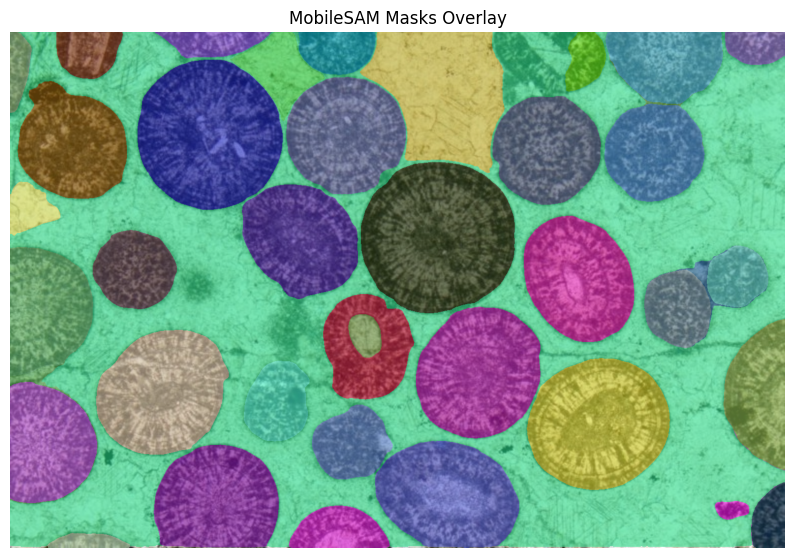

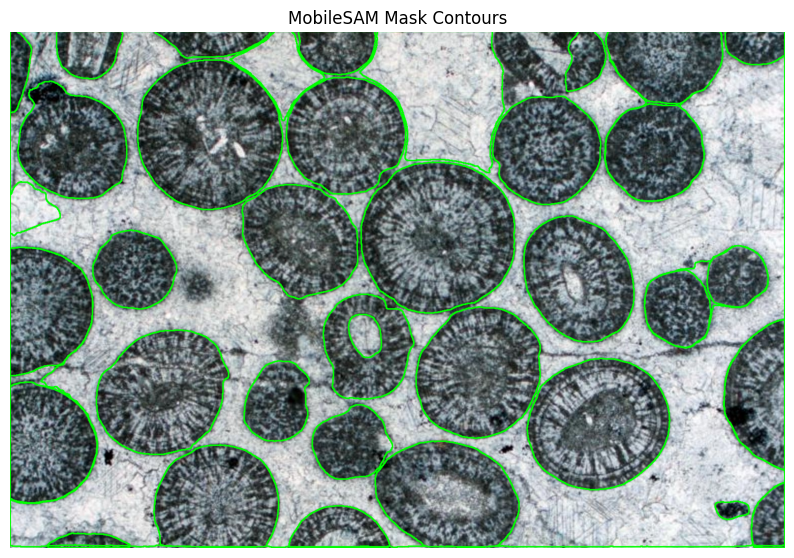

In [31]:

# Visualize masks overlay
plt.figure(figsize=(10,10))
plt.imshow(image_rgb) # Use the RGB image for display
show_anns(masks)
plt.title(f'{MODEL_VARIANT} Masks Overlay')
plt.axis('off')
plt.show()

# Visualize contours
# Use the original BGR image for cv2.drawContours, then convert back to RGB for matplotlib
contoured_image = draw_mask_contours(image_bgr, masks, color=(0, 255, 0), thickness=2) 
plt.figure(figsize=(10,10))
plt.imshow(contoured_image)
plt.title(f'{MODEL_VARIANT} Mask Contours')
plt.axis('off')
plt.show()



# Process Masks and Load Ground Truth

Convert the generated masks into structured grain data and load the ground truth annotations.


In [32]:

# Process SAM masks into grain annotations
print("Processing SAM masks to extract grain properties...")
# The get_sam_annotations_from_masks function uses AMBG_PARAMS internally for filtering,
# so pass it implicitly via the global scope, or pass specific params if preferred.
sam_annotations = get_sam_annotations_from_masks(masks, SCALE_FACTOR, image_width, image_height, coverage_threshold=0.95) # Using a default coverage threshold
print(f"Extracted {len(sam_annotations)} potential grain annotations from SAM masks.")

# Load Ground Truth data
print(f"Loading ground truth annotations from {GROUND_TRUTH_ANNOTATION_PATH}...")
if not os.path.exists(GROUND_TRUTH_ANNOTATION_PATH):
    print(f"Warning: Ground truth annotation file not found at {GROUND_TRUTH_ANNOTATION_PATH}.")
    print("Skipping evaluation against ground truth.")
    gt_data = [] # Set to empty list to skip evaluation
else:
    try:
        with open(GROUND_TRUTH_ANNOTATION_PATH, 'r') as f:
            gt_data = json.load(f)
        print(f"Loaded {len(gt_data)} ground truth grain annotations.")

        # Basic check for expected keys in GT data
        if gt_data and ('pixel_coords' not in gt_data[0] or 'grain_id' not in gt_data[0]):
             print("Warning: Ground truth data might not be in the expected format ('pixel_coords', 'grain_id').")
             print("Attempting to add 'grain_id' if missing...")
             # Attempt to add a simple grain_id if missing, assuming list of grain dicts
             if 'grain_id' not in gt_data[0]:
                  for i, grain in enumerate(gt_data):
                       grain['grain_id'] = i + 1
             # Further validation could be added here if needed

    except Exception as e:
        print(f"Error loading ground truth JSON from {GROUND_TRUTH_ANNOTATION_PATH}: {e}")
        print("Skipping evaluation against ground truth.")
        gt_data = [] # Set to empty list to skip evaluation



Processing SAM masks to extract grain properties...
Processing 42 SAM masks...
Extracted properties for 42 potential grains.
Extracted 42 potential grain annotations from SAM masks.
Loading ground truth annotations from annotations/Ooid.json...
Loaded 34 ground truth grain annotations.


# Evaluate Segmentation Matching Performance

Match predicted grains to ground truth based on spatial overlap and calculate precision, recall, and F1-score.

This step is only performed if ground truth data was successfully loaded.


In [33]:

if gt_data:
    # Perform grain matching
    # Use the full list of SAM annotations (sam_annotations) and the loaded ground truth (gt_data)
    print("\nPerforming grain matching for evaluation...")
    matches, matched_pred_data, unmatched_preds = fast_match_grains(
        gt_data,
        sam_annotations,
        image_width,
        image_height,
        iou_threshold=IOU_THRESHOLD,
        max_distance=CENTROID_MATCH_DISTANCE
    )
    print("Matching complete.")

    # Calculate segmentation metrics
    metrics = calculate_metrics(gt_data, sam_annotations, matches, unmatched_preds)

    # Print results
    print("\nSegmentation Performance Metrics:")
    for key, value in metrics.items():
        if isinstance(value, float):
            print(f"{key.replace('_', ' ').title()}: {value:.4f}")
        else:
             print(f"{key.replace('_', ' ').title()}: {value}")

else:
    print("\nSkipping segmentation matching evaluation: Ground truth data not loaded.")
    matches = {} # Ensure matches dictionary is empty if no GT
    matched_pred_data = {} # Ensure matched_pred_data is empty if no GT
    unmatched_preds = sam_annotations # If no GT, all predictions are effectively 'unmatched' for this metric

    # Create a placeholder metrics dictionary with NaN values
    metrics = {
        "total_predictions": len(sam_annotations),
        "total_ground_truth": len(gt_data), # Will be 0
        "true_positives": 0,
        "false_positives": len(sam_annotations), # All predictions are FP if no GT
        "false_negatives": len(gt_data), # All GT are FN if no preds (or no GT loaded)
        "precision": np.nan,
        "recall": np.nan,
        "f1_score": np.nan,
        "matched_gt_count": 0,
        "matched_pred_count": 0,
        "unmatched_pred_count": len(sam_annotations)
    }



Performing grain matching for evaluation...
Attempting to match 34 ground truth grains with 42 predictions...
Creating masks for IoU calculation...
Starting matching process...
Matching complete.
  Total ground truth grains processed for matching: 34
  Total predictions processed for matching: 42
  Successfully matched GT grains: 32
  Matched predictions count: 32
  Unmatched predictions (FP) count: 10
Matching complete.

Segmentation Performance Metrics:
Total Predictions: 42
Total Ground Truth: 34
True Positives: 32
False Positives: 10
False Negatives: 2
Precision: 0.7619
Recall: 0.9412
F1 Score: 0.8421
Matched Gt Count: 32
Matched Pred Count: 32
Unmatched Pred Count: 10


In [34]:


# %% [markdown]
## Visualize Matching Results
# 
# Display the image highlighting matched and unmatched grains. This step is only performed if ground truth data was successfully loaded, as it requires knowing which predictions correspond to ground truth grains.



Visualizing matched and unmatched grains...


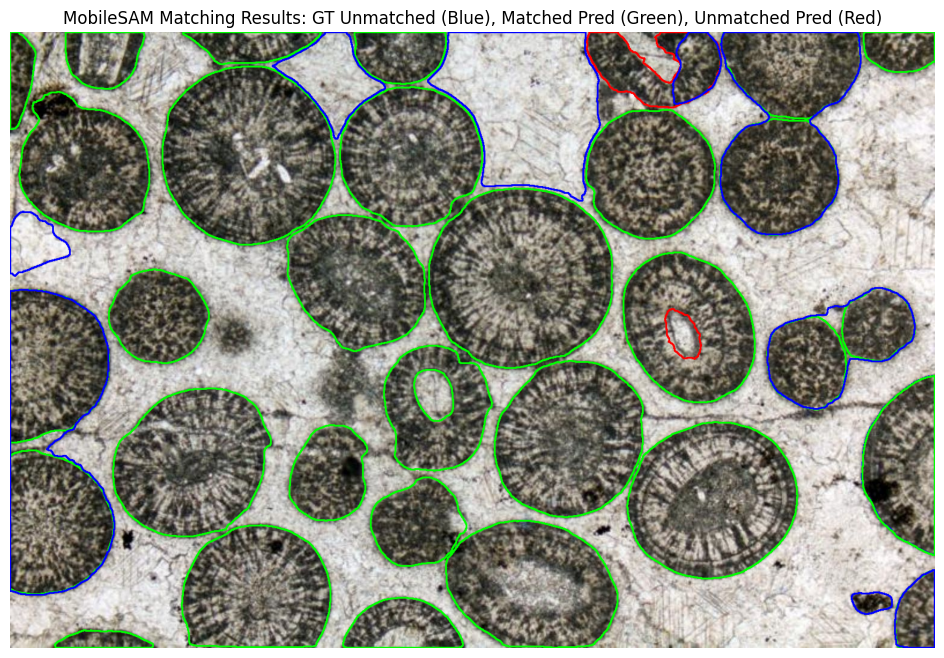

In [35]:

# %%
if gt_data:
    # Visualize matched vs unmatched contours
    # GT unmatched (FN) in Blue, Matched predictions (TP) in Green, Unmatched predictions (FP) in Red
    print("\nVisualizing matched and unmatched grains...")
    matched_unmatched_image = draw_matched_and_unmatched(
        image_rgb, # Use RGB image for matplotlib display
        gt_data,
        sam_annotations, # Pass all_pred_grains
        matches,
        unmatched_preds
    )

    plt.figure(figsize=(12,8))
    plt.imshow(matched_unmatched_image)
    plt.title(f'{MODEL_VARIANT} Matching Results: GT Unmatched (Blue), Matched Pred (Green), Unmatched Pred (Red)')
    plt.axis('off')
    plt.show()
else:
    print("\nSkipping matching visualization: Ground truth data not loaded.")
    # Optionally, visualize *all* predicted contours in a single color if no GT
    print("Visualizing all predicted contours instead.")
    all_pred_contoured_image = draw_mask_contours(image_bgr, masks, color=(0, 165, 255), thickness=2) # Orange contours
    plt.figure(figsize=(10,10))
    plt.imshow(all_pred_contoured_image)
    plt.title(f'{MODEL_VARIANT} All Predicted Contours (No GT Loaded)')
    plt.axis('off')
    plt.show()




# Analyze Grain Size Distributions

Compare the grain size (area) and length distributions from ground truth, all predictions, and matched predictions.



Analyzing grain size distributions...

Distribution Data Counts:
  Ground Truth grains: 34
  All predictions: 42
  Matched predictions: 32

Summary Statistics:
         GT_Areas  GT_Lengths  All_Pred_Areas  All_Pred_Lengths  \
count     34.0000   34.000000       42.000000         42.000000   
mean   12881.6616  145.041821    13015.090229        144.973989   
std     8918.7103   42.184200     9328.161715         56.369836   
min     1554.5888   62.338544      858.445600         45.496416   
25%     5401.1788  112.212528     4733.068600        103.623270   
50%    12437.8664  152.211702    12204.007600        146.844576   
75%    19474.2072  178.488008    19459.063600        179.379494   
max    34192.3992  212.750810    33462.963200        344.760000   

       Matched_Areas  Matched_Lengths  
count      32.000000        32.000000  
mean    13125.794775       141.922649  
std      8775.521207        41.338538  
min      1652.848800        59.994727  
25%      5185.295800       107.4570

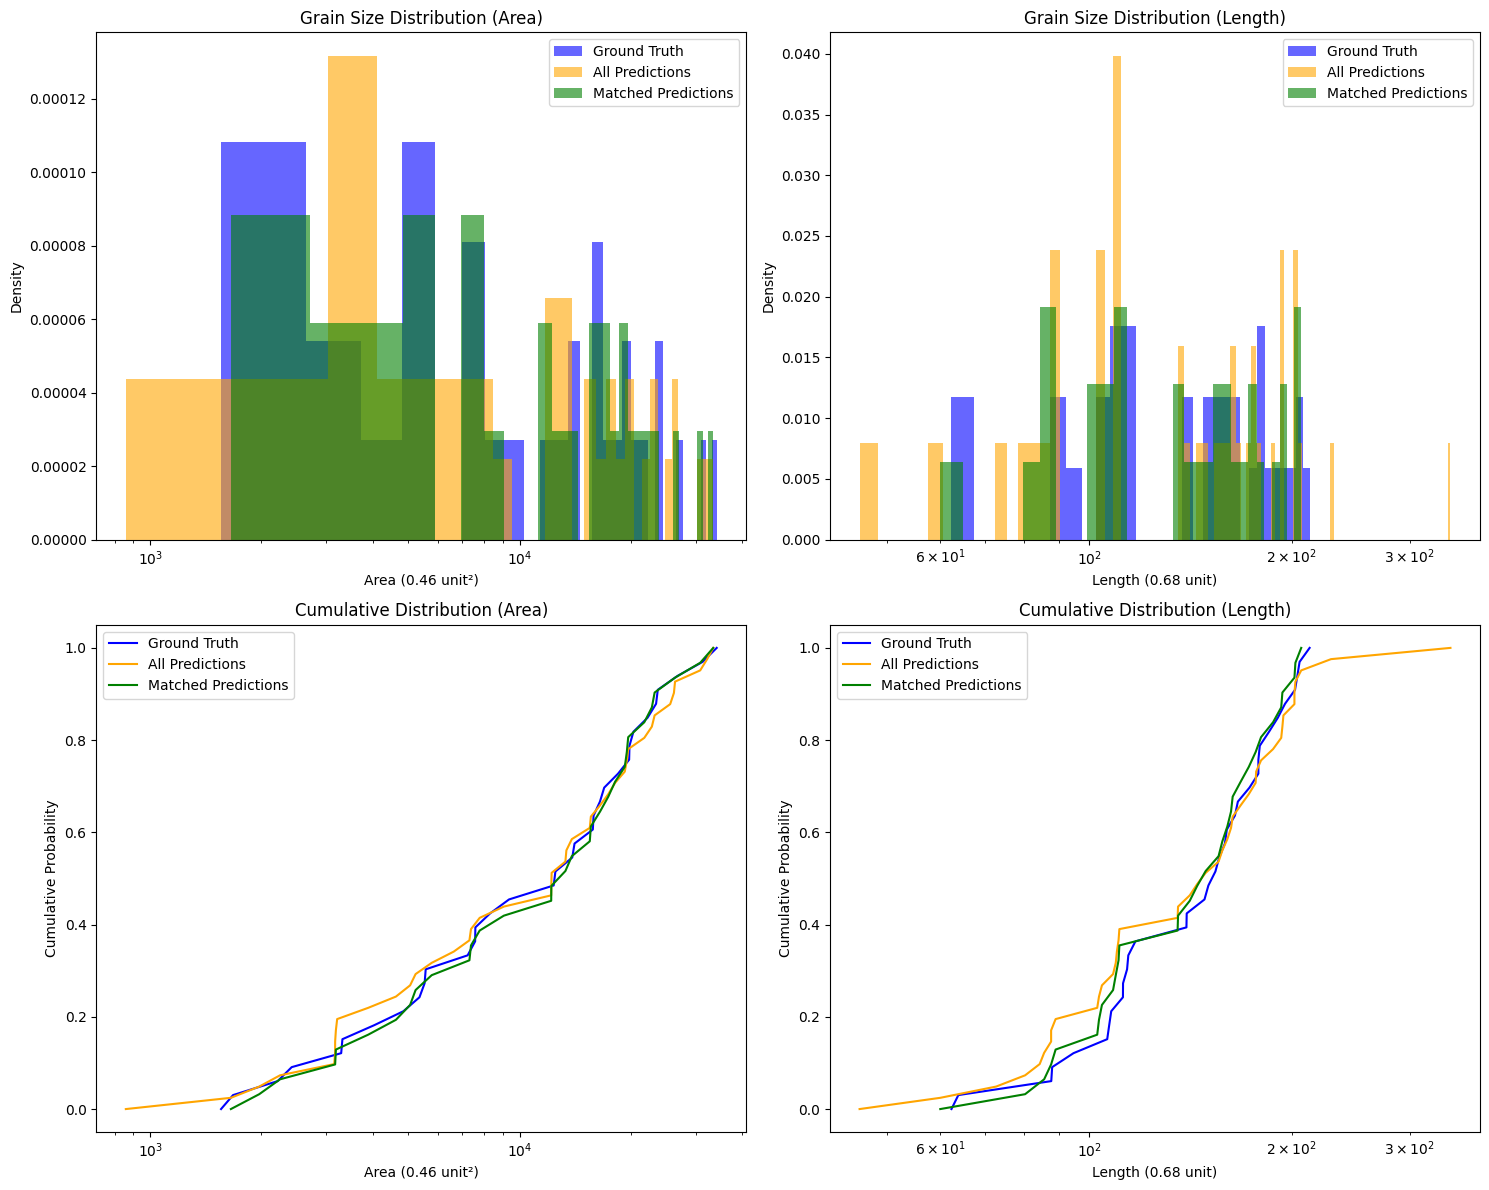


Evaluating distribution similarity (Matched Predictions vs. Ground Truth):

Area Distribution Metrics:
  Ks Statistic: 0.0772
  Ks Pvalue: 0.9995
  Nrmse Range: 0.0187
  Nrmse Mean: 0.0473

Length Distribution Metrics:
  Ks Statistic: 0.1397
  Ks Pvalue: 0.8431
  Nrmse Range: 0.0306
  Nrmse Mean: 0.0317


In [36]:

print("\nAnalyzing grain size distributions...")
df_stats, gt_sizes, all_pred_sizes, matched_pred_sizes, gt_lengths, all_pred_lengths, matched_pred_lengths = analyze_grain_distributions(
    gt_data, sam_annotations, matched_pred_data
)

# Evaluate distribution similarity using KS statistic and NRMSE (only if GT and matched predictions exist)
distribution_metrics = {}
if len(gt_sizes) > 1 and len(matched_pred_sizes) > 1:
    print("\nEvaluating distribution similarity (Matched Predictions vs. Ground Truth):")
    area_dist_metrics = evaluate_distribution_similarity(gt_sizes, matched_pred_sizes)
    length_dist_metrics = evaluate_distribution_similarity(gt_lengths, matched_pred_lengths)

    print("\nArea Distribution Metrics:")
    for key, value in area_dist_metrics.items():
        if isinstance(value, float):
            print(f"  {key.replace('_', ' ').title()}: {value:.4f}")
        else:
             print(f"  {key.replace('_', ' ').title()}: {value}")

    print("\nLength Distribution Metrics:")
    for key, value in length_dist_metrics.items():
         if isinstance(value, float):
              print(f"  {key.replace('_', ' ').title()}: {value:.4f}")
         else:
              print(f"  {key.replace('_', ' ').title()}: {value}")

    # Combine all distribution metrics into a single dictionary for saving
    distribution_metrics = {
        'Area_KS_Statistic': area_dist_metrics.get('ks_statistic', np.nan),
        'Area_KS_PValue': area_dist_metrics.get('ks_pvalue', np.nan),
        'Area_NRMSE_Range': area_dist_metrics.get('nrmse_range', np.nan),
        'Area_NRMSE_Mean': area_dist_metrics.get('nrmse_mean', np.nan),
        'Length_KS_Statistic': length_dist_metrics.get('ks_statistic', np.nan),
        'Length_KS_PValue': length_dist_metrics.get('ks_pvalue', np.nan),
        'Length_NRMSE_Range': length_dist_metrics.get('nrmse_range', np.nan),
        'Length_NRMSE_Mean': length_dist_metrics.get('nrmse_mean', np.nan),
    }
else:
     print("\nSkipping distribution similarity evaluation: Not enough data in Ground Truth or Matched Predictions.")
     distribution_metrics = { # Placeholder with NaN values
         'Area_KS_Statistic': np.nan, 'Area_KS_PValue': np.nan, 'Area_NRMSE_Range': np.nan, 'Area_NRMSE_Mean': np.nan,
         'Length_KS_Statistic': np.nan, 'Length_KS_PValue': np.nan, 'Length_NRMSE_Range': np.nan, 'Length_NRMSE_Mean': np.nan,
     }




# Save Results

Save the calculated metrics and detailed distribution data to CSV and Excel files.


In [37]:

# Save segmentation metrics (always save, even if empty/NaN)
metrics_output_path = os.path.join(OUTPUT_RESULTS_DIR, "segmentation_metrics.csv")
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv(metrics_output_path, index=False)
print(f"\nSegmentation metrics saved to: {metrics_output_path}")


# Save distribution similarity metrics (always save, even if empty/NaN)
dist_metrics_output_path = os.path.join(OUTPUT_RESULTS_DIR, "distribution_similarity_metrics.csv")
dist_metrics_df = pd.DataFrame([distribution_metrics])
dist_metrics_df.to_csv(dist_metrics_output_path, index=False)
print(f"Distribution similarity metrics saved to: {dist_metrics_output_path}")


# Save detailed distribution data (raw and cumulative)
output_distribution_file = os.path.join(OUTPUT_RESULTS_DIR, 'grain_distributions_comprehensive.xlsx')

try:
    with pd.ExcelWriter(output_distribution_file) as writer:
        # Raw distributions (handle cases where arrays might be empty)
        if gt_sizes.size > 0 or gt_lengths.size > 0:
             gt_raw_df = pd.DataFrame()
             if gt_sizes.size > 0: gt_raw_df['Ground_Truth_Areas'] = gt_sizes
             if gt_lengths.size > 0: gt_raw_df['Ground_Truth_Lengths'] = gt_lengths
             if not gt_raw_df.empty:
                  gt_raw_df.to_excel(writer, sheet_name='Ground_Truth_Raw', index=False)
             else:
                  print("Warning: Ground Truth Raw data is empty, skipping sheet.")


        if all_pred_sizes.size > 0 or all_pred_lengths.size > 0:
             all_pred_raw_df = pd.DataFrame()
             if all_pred_sizes.size > 0: all_pred_raw_df['All_Predictions_Areas'] = all_pred_sizes
             if all_pred_lengths.size > 0: all_pred_raw_df['All_Predictions_Lengths'] = all_pred_lengths
             if not all_pred_raw_df.empty:
                  all_pred_raw_df.to_excel(writer, sheet_name='All_Predictions_Raw', index=False)
             else:
                  print("Warning: All Predictions Raw data is empty, skipping sheet.")

        if matched_pred_sizes.size > 0 or matched_pred_lengths.size > 0:
             matched_raw_df = pd.DataFrame()
             if matched_pred_sizes.size > 0: matched_raw_df['Matched_Predictions_Areas'] = matched_pred_sizes
             if matched_pred_lengths.size > 0: matched_raw_df['Matched_Predictions_Lengths'] = matched_pred_lengths
             if not matched_raw_df.empty:
                  matched_raw_df.to_excel(writer, sheet_name='Matched_Predictions_Raw', index=False)
             else:
                  print("Warning: Matched Predictions Raw data is empty, skipping sheet.")


        # Calculate and save cumulative distributions
        gt_area_sorted, gt_area_cum = calculate_cumulative_data(gt_sizes)
        gt_length_sorted, gt_length_cum = calculate_cumulative_data(gt_lengths)
        all_pred_area_sorted, all_pred_area_cum = calculate_cumulative_data(all_pred_sizes)
        all_pred_length_sorted, all_pred_length_cum = calculate_cumulative_data(all_pred_lengths)
        matched_area_sorted, matched_area_cum = calculate_cumulative_data(matched_pred_sizes)
        matched_length_sorted, matched_length_cum = calculate_cumulative_data(matched_pred_lengths)

        if gt_area_sorted.size > 0 or gt_length_sorted.size > 0:
            gt_cum_df = pd.DataFrame()
            if gt_area_sorted.size > 0:
                 gt_cum_df['Area'] = gt_area_sorted
                 gt_cum_df['Area_Cumulative'] = gt_area_cum
            if gt_length_sorted.size > 0:
                 gt_cum_df['Length'] = gt_length_sorted
                 gt_cum_df['Length_Cumulative'] = gt_length_cum
            if not gt_cum_df.empty:
                 gt_cum_df.to_excel(writer, sheet_name='Ground_Truth_Cumulative', index=False)
            else:
                 print("Warning: Ground Truth Cumulative data is empty, skipping sheet.")


        if all_pred_area_sorted.size > 0 or all_pred_length_sorted.size > 0:
             all_pred_cum_df = pd.DataFrame()
             if all_pred_area_sorted.size > 0:
                  all_pred_cum_df['Area'] = all_pred_area_sorted
                  all_pred_cum_df['Area_Cumulative'] = all_pred_area_cum
             if all_pred_length_sorted.size > 0:
                  all_pred_cum_df['Length'] = all_pred_length_sorted
                  all_pred_cum_df['Length_Cumulative'] = all_pred_length_cum
             if not all_pred_cum_df.empty:
                 all_pred_cum_df.to_excel(writer, sheet_name='All_Predictions_Cumulative', index=False)
             else:
                  print("Warning: All Predictions Cumulative data is empty, skipping sheet.")


        if matched_area_sorted.size > 0 or matched_length_sorted.size > 0:
            matched_cum_df = pd.DataFrame()
            if matched_area_sorted.size > 0:
                 matched_cum_df['Area'] = matched_area_sorted
                 matched_cum_df['Area_Cumulative'] = matched_area_cum
            if matched_length_sorted.size > 0:
                 matched_cum_df['Length'] = matched_length_sorted
                 matched_cum_df['Length_Cumulative'] = matched_length_cum
            if not matched_cum_df.empty:
                 matched_cum_df.to_excel(writer, sheet_name='Matched_Cumulative', index=False)
            else:
                 print("Warning: Matched Cumulative data is empty, skipping sheet.")


        # Save statistics (using the df_stats DataFrame computed earlier)
        if not df_stats.empty:
             # Ensure 'Metric' column is the first column
             stats_df_to_save = df_stats.copy()
             stats_df_to_save.reset_index(inplace=True)
             stats_df_to_save.rename(columns={'index': 'Metric'}, inplace=True)
             stats_df_to_save.to_excel(writer, sheet_name='Statistics', index=False)
        else:
             print("Warning: No statistics data to save.")


        # Save Percentiles (handle cases where arrays might be empty)
        percentiles = [0, 10, 25, 50, 75, 90, 100]
        percentile_data = {'Percentile': percentiles}

        if gt_sizes.size > 0:
             percentile_data['GT_Areas'] = np.percentile(gt_sizes, percentiles)
             percentile_data['GT_Lengths'] = np.percentile(gt_lengths, percentiles)
        if all_pred_sizes.size > 0:
             percentile_data['All_Pred_Areas'] = np.percentile(all_pred_sizes, percentiles)
             percentile_data['All_Pred_Lengths'] = np.percentile(all_pred_lengths, percentiles)
        if matched_pred_sizes.size > 0:
             percentile_data['Matched_Areas'] = np.percentile(matched_pred_sizes, percentiles)
             percentile_data['Matched_Lengths'] = np.percentile(matched_pred_lengths, percentiles)

        # Check if any percentile columns were added beyond just 'Percentile'
        if len(percentile_data) > 1:
            pd.DataFrame(percentile_data).to_excel(writer, sheet_name='Percentiles', index=False)
        else:
            print("Warning: No percentile data to save.")


    print(f"Comprehensive distribution data saved to '{output_distribution_file}'")

except ImportError:
     print("\nError: Required library 'openpyxl' not found.")
     print("Please install it to save results to Excel: pip install openpyxl")
except Exception as e:
     print(f"\nError saving comprehensive distribution data to Excel: {e}")




Segmentation metrics saved to: results/mobilesam_example\segmentation_metrics.csv
Distribution similarity metrics saved to: results/mobilesam_example\distribution_similarity_metrics.csv
Comprehensive distribution data saved to 'results/mobilesam_example\grain_distributions_comprehensive.xlsx'



# Conclusion

This notebook presents a complete workflow, starting with mask generation using a SAM variant (demonstrated with MobileSAM) and culminating in the quantitative evaluation of segmentation performance and grain size distribution accuracy against ground truth data. It serves as a foundation for users to apply and evaluate various lightweight SAM models for automated petrographic analysis. Users can modify the configuration parameters and model loading logic to experiment with different SAM variants and integrate this code into more extensive petrographic analysis pipelines.